# Proteína CDK2

## Modelado de los residuos restantes de los cristales con Modeller
En esta libreta se utiliza Modeller para modelar las regiones faltantes de las estructuras cristalogŕaficas de la proteína de interés.

> El proceso consite en cargar el pdb con la cadena protéica correpondiente a la proteína, identificar las regiones faltantes con respecto a la secuencia total, obtenida de UniProt, y en utilizar *Modeller* para modelar y refinar únicamente los residuos de los gaps sin alterar las coordenadas de los átomos ya presentes en la estructura original.

In [1]:
# Librerías
from prody import *
from Bio import pairwise2, SeqIO
import os, glob, sys

### Obtener la secuencia de UniProt
Utilizamos la secuencia P24941 correspondiente a la CDK2 humana.

In [2]:
# Nombre de la proteina de interes
prot_name = 'cdk2'
# Secuencia P28482 (ERK2_HUMAN)
uniprot_id = "P24941"
# Directorio de metadatos
DIR_DATA = '../data/'

In [17]:
# Secuencia de la CDK2 de UniProt
file_name_fasta = '../data/' + uniprot_id + '.fasta'
fasta_prot = SeqIO.read(open(file_name_fasta),'fasta')
seq_prot = str(fasta_prot.seq)
print(seq_prot)

MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPSTAIREISLLKELNHPNIVKLLDVIHTENKLYLVFEFLHQDLKKFMDASALTGIPLPLIKSYLFQLLQGLAFCHSHRVLHRDLKPQNLLINTEGAIKLADFGLARAFGVPVRTYTHEVVTLWYRAPEILLGCKYYSTAVDIWSLGCIFAEMVTRRALFPGDSEIDQLFRIFRTLGTPDEVVWPGVTSMPDYKPSFPKWARQDFSKVVPPLDEDGRSLLSQMLHYDPNKRISAKAALAHPFFQDVTKPVPHLRL


### Función find gaps
Cargamos la función que permite permite identificar los gaps en una secuencia y devolver el rango del gap.

In [7]:
import sys
# Añadimos la ruta del directorio raíz para tener acceso a los archivos y módulos
sys.path.append(r'..')
from modules.find_gaps import find_gaps
# Recibe una secuencia (con gaps como "-") y un valor r para valorar el gap en +/- r posiciones 

In [8]:
# EJEMPLO:
find_gaps("1234-5", r=2)

{'num_gaps': 1,
 'gap_lengths': [2],
 'gap_list': [[5, 6]],
 'gap_window': [[3, 6]]}

### Obtenemos los PDB IDs de los cristales
A partir de la tabal de metadatos generada con *Get_Metadatos..*.  
Tomar en cuenta que de los **408** cristales identificados, **seis han sido removidos**, debido a que el modelado no era posible:
- 5ang, 4ek6, 6ath, 5uq3, 1jsu, 5mhq.

In [9]:
# Los IDs de los cristales están en el archivo
import pandas as pd
file_path = glob.glob(F"{DIR_DATA}/TABLA_MTDATA_{prot_name.upper()}_*.csv")[0]
df_prot = pd.read_csv(file_path, index_col=1)
pdbids_list = df_prot.index
print("Total de PDB IDs a modelar:", len(pdbids_list))

Total de PDB IDs a modelar: 402


***
# Modeller
## Se ejecuta Modeller para refinamiento por loops
#### Descripción de los pasos a ejecutar:
- **1)** Se definen los directorios de entradas y salidas.
- **2)** Se carga la estructura cristalográfica a modelar (*cristal*), correspondiente a cada pdb id.
    - Si la proteína ya fue modelada se omite volver a modelarla.
- **3)** Se hace un alineamiento de la secuencia del cristal y la secuecnia **P24941**.
- **4)** Se identifican los gaps en la secuencia del cristal, si los hay. Se define una ventana de $\pm$ *r* residuos que se considerarán dentro del gap.
- **5)** Se modifica el método *select_atoms* de la clase *MyModel* de MODELLER para indicar que únicamente modele los residuos que pertenecen al gap del cristal, dejando intacto el resto de los átomos de la proteína.
- **6)** Ejecuta MODELLER con los parámetros indicados, generando únicamente un modelo, el cual es guardado como _PDBID_**_MODLL.pdb**.

In [14]:
# Directiros y parámetros base
struct_dir = F'../../ARCHIVOS/CRISTALES/PROT_{prot_name.upper()}_CHAINS/'
tail_pdb = '_A.pdb' # extensión del archivo pdb del cristal
tail_model = '_MODLL' # epiteto del archivo del modelo final, la extensión .pdb la agrega modeller
pdbs_model_dir = F"../../ARCHIVOS/CRISTALES/PROT_{prot_name.upper()}_MODELOS_modeller_NoPrep/" # Carpeta de salida para los modelos

# Creamos el directorio de salida si es que no existe
if not os.path.exists(pdbs_model_dir):
    os.makedirs(pdbs_model_dir)

In [15]:
from modeller import * # licencia modeller necesaria
from modeller.automodel import *
def run_modeller(pdb_code, num_res_window = 2, force_modeling = False,
                max_var_iterations = 500, repeat_optimization = 2):
    '''función para modelar gaps en estructuras cristalográficas utilizando Modeller'''
    ###########################
    if not force_modeling:
        if os.path.isfile(pdbs_model_dir + pdb_code + tail_model + ".pdb"):
            return print("El modelo ya existe en el directorio")
    ###########################
    try:
        # Se lee el archivo pdb. La selección omite residuos negativos.
        # Además omite los residuos no estandar, o con modificaciones 
        # postraduccionales como el TPO (Tirosina fosfatada)
        stc_prot = parsePDB(struct_dir 
                            + pdb_code + tail_pdb).select('not nonstdaa and resid > 0') 
        chaid = stc_prot.getChids()[0] # Obtiene el id de la cadena
        ref_hv = stc_prot.getHierView()[chaid] # Se obtiene sólo la cadena
        seq_cry = ref_hv.getSequence() # Se obtiene la secuencia de la estructura cristalográfica   
    except:
        return print("Error al abrir y modelar:", pdb_code)
    ########################### 
    # Pregunta si la longitud y la secuencias de Uniprot y de la estructura son iguales
    same_seq = len(seq_cry) == len(seq_prot) and seq_cry == seq_prot
    # si same_seq es verdadero, se omite hacer el modelado pues la estructura está completa
    if same_seq:
        return print("La proteína " + pdb_code + " ya está completa") 
        # Si le hacen falta átomos a un residuo fuera del gap, esto se corregirá 
        # con PDB2PQR y pdb4amber en un fase posterior al modelado.
    ###########################     
    print("Modelando proteína " + pdb_code)
    # Obtener la secueNcia de la estructura a modelar y guardarla en un archivo.
    # Alineamiento global, se penalizan con -10 la abertura de nuevos gaps, se obtiene el mejor alineamiento.
    alignment = pairwise2.align.globalxs(seq_cry, seq_prot, -10, -0.5, gap_char='-')[0]
    # Secuencias del alineamiento
    algn1_struc = alignment[0] # Secuencia alineada de la estructura cristalográfica
    algn2_seq = seq_prot # Secuencia completa de UniProt

    # Nombre de los cabezales de las secuencia deben coincidir con el de los archivos de entrada y salida
    crys_file_name = pdb_code + tail_pdb
    model_file_name = pdb_code + tail_model

    ''' NECESARIO: There should be 10 fields separated by colons ":".
    Please check the file to make sure your sequences end with the '*' character.
    Nomenclaturas de los campos del header: 
    https://salilab.org/modeller/8v2/manual/node176.html'''

    # HEADERS (la secuencia del cristal va primero, luego la secuencia completa)
    struc_header = "structureX:" + crys_file_name + ":.:" + chaid + ":.:" + chaid + ":.:.:.:"
    seq_header = "sequence:" + model_file_name + ":.:.:.:.:.:.:.:"
    
    # Crea el archivo de alineamiento con la estructura requerida por modeller
    alg_filename = pdb_code + ".alg"
    with open(alg_filename, "w") as handle:
        handle.write("\n>P1;%s\n%s\n%s*\n>P1;%s\n%s\n%s*\n" % (crys_file_name, struc_header, algn1_struc, 
                                                               model_file_name, seq_header, algn2_seq))
    ##########################
    # Ejecuta find_gaps para obtener los posibles gaps de la secuencia
    gaps = find_gaps(algn1_struc, r = num_res_window)
    num_gaps = gaps["num_gaps"]
    gap_i = gaps["gap_window"]
    
    # Se crea el string que necesita Modeller para definir al primer gap
    s = "self.residue_range('" + str(gap_i[0][0]) + "', '" + str(gap_i[0][1]) + "')"

    # A pesar de que sólo haya un gap, se ejecuta el ciclo, 
    # si hay más de uno, se extiende el String para incluir los demás
    for i in range(1, num_gaps): 
        s = s + ", " + "self.residue_range('" + str(gap_i[i][0]) + "', '" + str(gap_i[i][1]) + "')" 
    ##########################
    ''' SE EJECUTA MODELLER'''
    ##########################
    # Se crea un nuvo ambiente de modeller
    env = environ()
    env.io.atom_files_directory = ['.', struct_dir]
    
    # Se modifica la clase MyModel de Modeller para fijar los residuos ya existentes en el cristal
    # Estos residuos no se modelarán ni sus átomos cambiarán de posición
    # NECESARIO para poder capturar los valores obtenidos por el rango de gaps
    
    MyModel_code = """
class MyModel(automodel):
    def select_atoms(self):
        return selection(""" + s + """)
""" # Al estar dentro del loop la identación de este string es importante
    exec(MyModel_code, globals()) # Se lleva a cabo la modificación a MyModel para agregar la región fijada
    # Se intancia el objeto MyModel
    a = MyModel(env, alnfile = alg_filename, # Lee el archivo fasta creado y guardado en el directorio actual
                      knowns = crys_file_name, # Archivo pdb crys, que coincide con el id en el archivo fasta
                      sequence = model_file_name) # Nombre del modelo
    a.starting_model= 1
    a.ending_model  = 1
    # Se definen los parámetros de refinamiento dle modelo:
    # Más info sobre el refinamiento: https://salilab.org/modeller/9.21/manual/node19.html
    a.library_schedule = autosched.slow # Originalmente comentado
    a.max_var_iterations = max_var_iterations #*500
    a.md_level = refine.slow # Nivel del refinamiento
    a.repeat_optimization = repeat_optimization # Número de repeticiones para la optimización
    a.make()

    ###########################
    # Renombra el archivo pdb a pdb_code + _full.pdb
    # DEBE ser el único archivo pdb en el directorio '.'
    model_file = glob.glob('./' + pdb_code + '*.pdb')[0] # Nombre del archivo pdb
    # Mueve el pdb a la carpeta model_pdbs
    os.rename(model_file, pdbs_model_dir + pdb_code + tail_model + ".pdb") 
    # Elimina los archivos extra generados - Todos empiezan con el codigo del PDB ID
    for f in glob.glob(pdb_code + "*"):
        os.remove(f)


## Ejecutamos modeller para cada estructura

In [18]:
import time
start = time.time()

# Se lleva a cabo el modelado de todas las estructuras cristalográficas
for pdb_code in pdbids_list:
    run_modeller(pdb_code, 
             num_res_window = 2, 
             force_modeling = True,
             max_var_iterations = 1000, 
             repeat_optimization = 2)

end = time. time()
print(end - start)

@> 2230 atoms and 1 coordinate set(s) were parsed in 0.03s.


Modelando proteína 1aq1

                         MODELLER 9.22, 2019/06/19, r11413

     PROTEIN STRUCTURE MODELLING BY SATISFACTION OF SPATIAL RESTRAINTS


                     Copyright(c) 1989-2019 Andrej Sali
                            All Rights Reserved

                             Written by A. Sali
                               with help from
              B. Webb, M.S. Madhusudhan, M-Y. Shen, G.Q. Dong,
          M.A. Marti-Renom, N. Eswar, F. Alber, M. Topf, B. Oliva,
             A. Fiser, R. Sanchez, B. Yerkovich, A. Badretdinov,
                     F. Melo, J.P. Overington, E. Feyfant
                 University of California, San Francisco, USA
                    Rockefeller University, New York, USA
                      Harvard University, Cambridge, USA
                   Imperial Cancer Research Fund, London, UK
              Birkbeck College, University of London, London, UK


Kind, OS, HostName, Kernel, Processor: 4, Linux ambar 4.15.0-66-generic x86_64
Date a


DISTANCE1:  0.00 2.10 2.20 2.30 2.40 2.50 2.60 2.70 2.80 2.90 3.00 3.10 3.20 3.30 3.40
DISTANCE2:  2.10 2.20 2.30 2.40 2.50 2.60 2.70 2.80 2.90 3.00 3.10 3.20 3.30 3.40 3.50
FREQUENCY:     0    0    0    0    1    4    9   42  104  121  175  198  279  340  370


<< end of ENERGY.

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
1aq1_MODLL.B99990001.pdb       141.97104

43.614641427993774


## Como resultado se modelaron 402 estructuras.
Para este punto se han descargado todos los cristales de cdk2 disponibles. Sin embargo, de los 408 iniciales, se descartarán **5ang** por tener una covertura menor al 50%.  
Adicionalmente  se descartaron **5ang, 4ek6, 6ath, 5uq3, 1jsu, 5mhq**, las cuales no fue posible modelar debido al loop A.

In [ ]:
### Ejmplo de uno estos modelos

In [31]:
import nglview as nv
import pytraj as pyt

prot_ejemplo = pyt.load('../../ARCHIVOS/CRISTALES/LOG_MODELLER_Modelos_descartados/5mhq_full.pdb')
view = nv.show_pytraj(prot_ejemplo)
view.clear_representations()
view.add_representation('cartoon')
view

NGLWidget()

In [32]:
view.render_image()

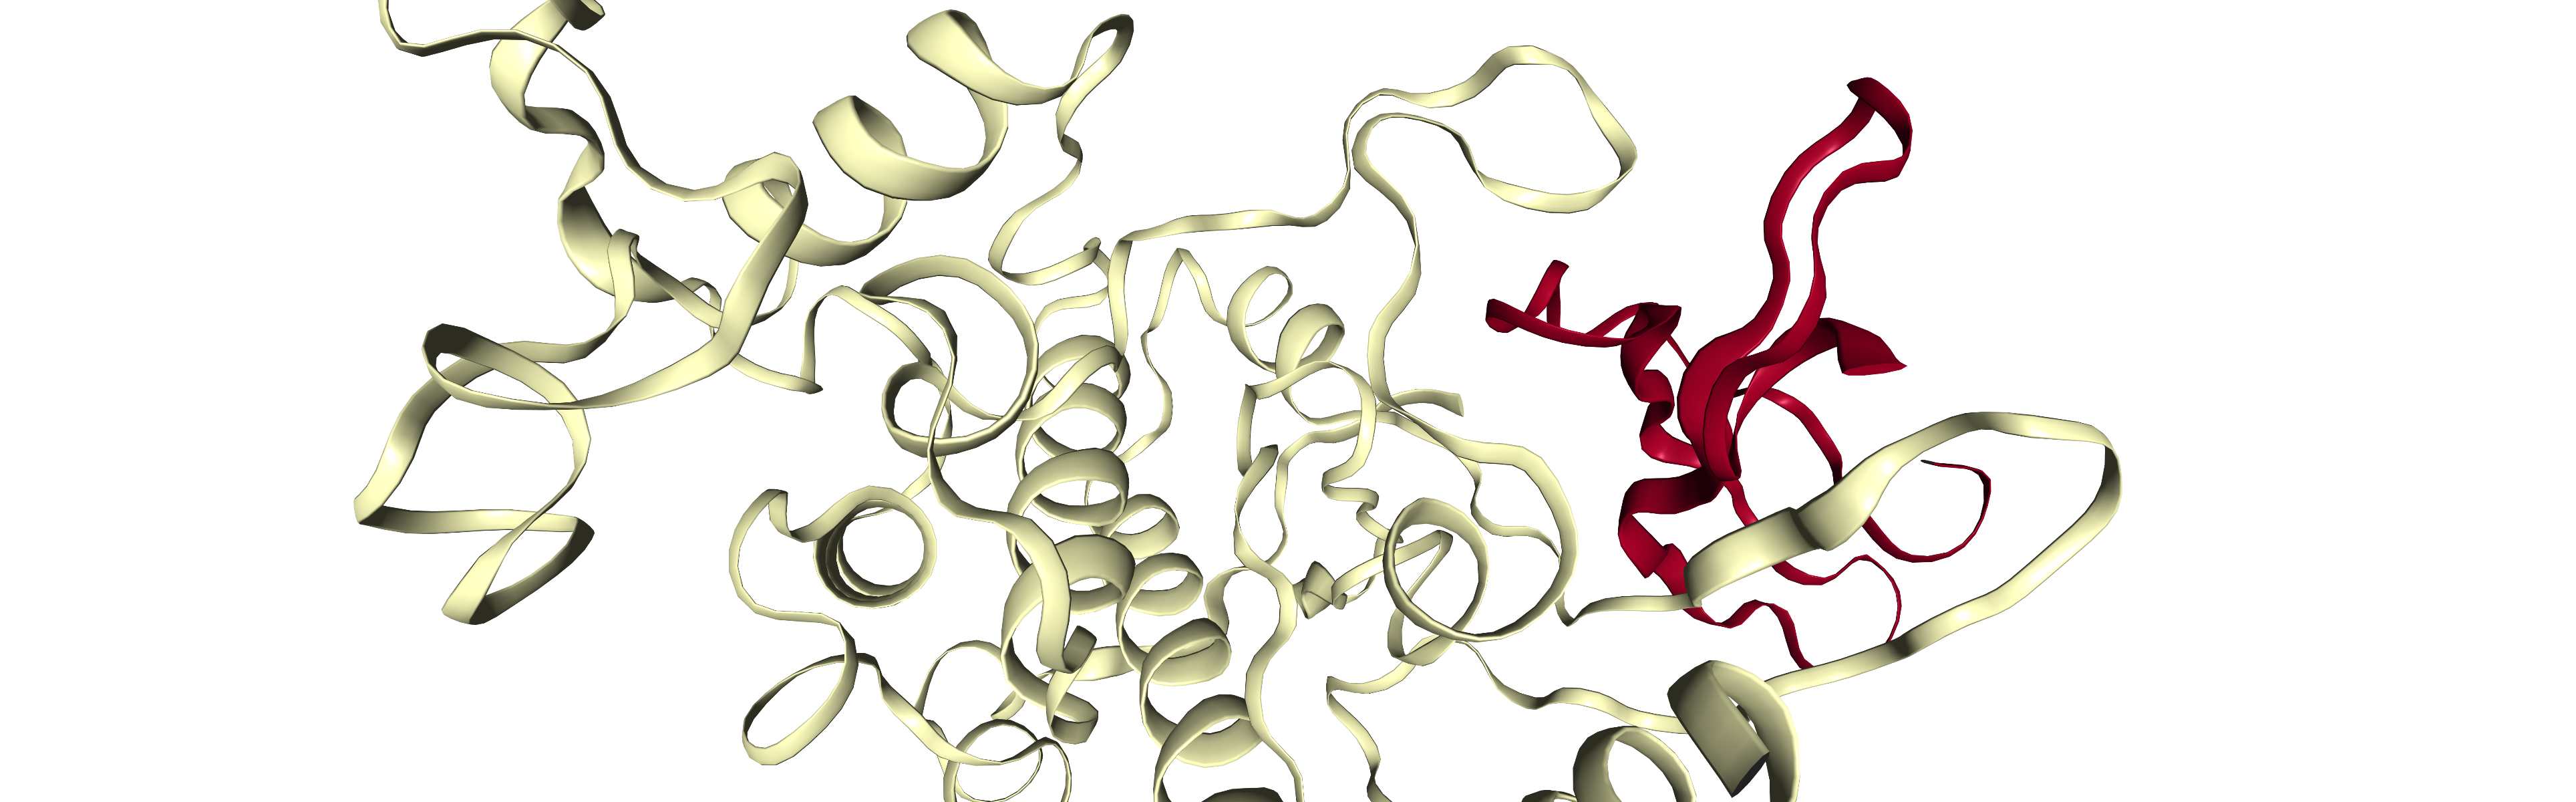

In [33]:
view._display_image()